### This script demonstrates how dithering can be applied to low-amplitude signals that are vulnerable to quantization error. After defining the constants, you may click the "Run All" button to run all cells in this script.

In [45]:
import matplotlib.pyplot as plt
import librosa
import numpy as np
from IPython.display import Audio

In [46]:
# Define some constants.
source = 'music'            # Either 'tone' or 'music'
use_colab = True            # Set to False if you use local IDE such as Visual Studio Code
sr = 16000                  # Sampling rate of the target signal
duration = 5                # Duration of the target signal
n_bits = 8                  # Bit depth for the quantized signal
amp_red_ratio= 32           # Reduce the amplitude of the signal by this factor
noise_var_ratio = 20        # Noise ratio for dithering

In [51]:
# Mount Google Drive and create a folder for the lab exercise
if use_colab == True:
  from google.colab import drive
  drive.mount('/content/drive')
  !mkdir -p /content/drive/MyDrive/Learning/EIE4435/Programs
  %cd /content/drive/MyDrive/Learning/EIE4435/Programs

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Learning/EIE4435/Programs


In [52]:
# Function for plotting one frame of unquantized waveform, one frame of quantized waveform, and their spectrograms
def plot_figure(x, xq, sr=16000, frm_len=512, hop_len=256):
    '''
    x: waveform
    xq: quantized waveform
    '''
    e = xq - x
    X = librosa.amplitude_to_db(np.abs(librosa.stft(x, n_fft=512, hop_length=256)), ref=np.max)  # STFT of y
    Xq = librosa.amplitude_to_db(np.abs(librosa.stft(xq, n_fft=512, hop_length=256)), ref=np.max)  # STFT of y
    E = librosa.amplitude_to_db(np.abs(librosa.stft(e, n_fft=512, hop_length=256)), ref=np.max)  # STFT of y

    _, ax = plt.subplots(nrows=3, sharex=True, figsize=(8,3))
    #ax[0].set_ylim([-1, 1])
    #ax[1].set_ylim([-1, 1])
    #ax[2].set_ylim([-0.01, 0.01])
    smp_idx = range(2*frm_len,3*frm_len)
    librosa.display.waveshow(x[smp_idx], sr=sr, ax=ax[0])
    librosa.display.waveshow(xq[smp_idx], sr=sr, ax=ax[1])
    librosa.display.waveshow(e[smp_idx], sr=sr, ax=ax[2])
    _, ax = plt.subplots(nrows=3, sharex=True, figsize=(8,3))
    librosa.display.specshow(X, sr=sr, n_fft=frm_len, hop_length=hop_len, x_axis='time', y_axis='linear', ax=ax[0])
    librosa.display.specshow(Xq, sr=sr, n_fft=frm_len, hop_length=hop_len, x_axis='time', y_axis='linear', ax=ax[1])
    librosa.display.specshow(E, sr=sr, n_fft=frm_len, hop_length=hop_len, x_axis='time', y_axis='linear', ax=ax[2])

In [53]:
# Function for performing quanitzation
def quantize(y, n_bits=8, xmax=1):
    Q = 2 * xmax/(2**n_bits)
    yq = y/2 * (2**(n_bits-1) + 2**(n_bits-1) - 1)
    yq = np.floor(yq).astype(int).astype(float)*Q
    #print(f"{n_bits}-bit audio ranges from -{2**(n_bits - 1)} to {2**(n_bits - 1) - 1}")
    #print(f"Max value: {np.max(yq)} Avg value: {np.mean(yq):.2f}")
    return yq

In [54]:
if source == 'music':
    # Load a wavefile and crop a 2-second segment from it
    x, fs = librosa.load('../AudioFiles/Bach.mp3', mono=True, offset=0.0, duration=duration)
    x = librosa.resample(x, orig_sr=fs, target_sr=sr)
    x = ((x-np.min(x))/(np.max(x)-np.min(x))-0.5)*2
else:
    # Generate a tone of 500Hz with a sampling rate of 16kHz
    x = librosa.tone(500, sr=sr, length=sr*2)
    x = ((x-np.min(x))/(np.max(x)-np.min(x))-0.5)*2

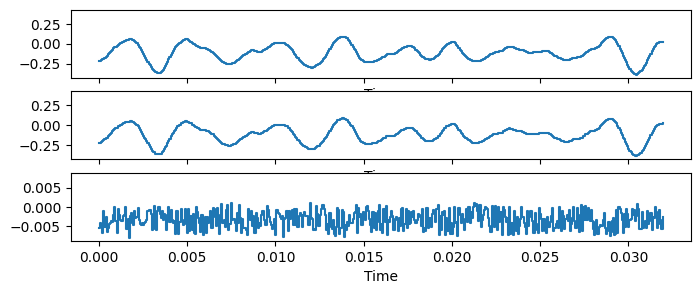

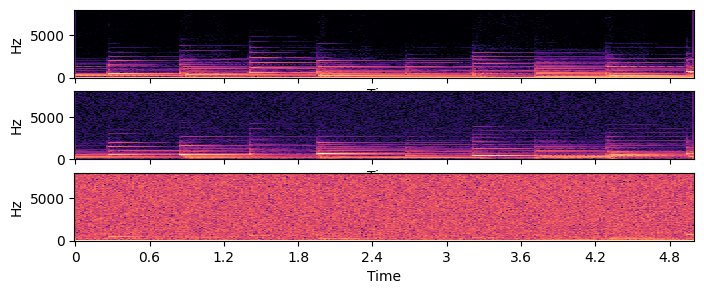

In [55]:
xq = quantize(x, n_bits=n_bits)
plot_figure(x, xq, sr=sr)

In [56]:
# Reduce the amplitude of the signal to make it more vulnerable to quanization error.
# Reduce the number of bits per sample
y = x/amp_red_ratio
yq = quantize(y, n_bits=n_bits, xmax=1)

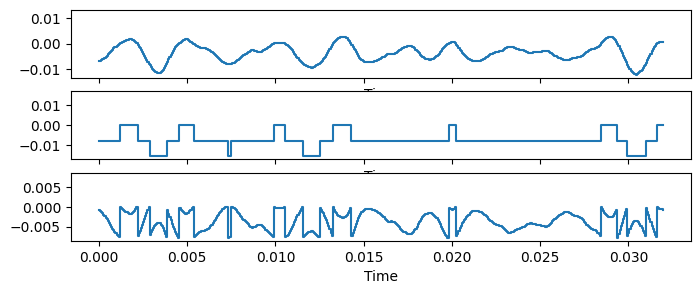

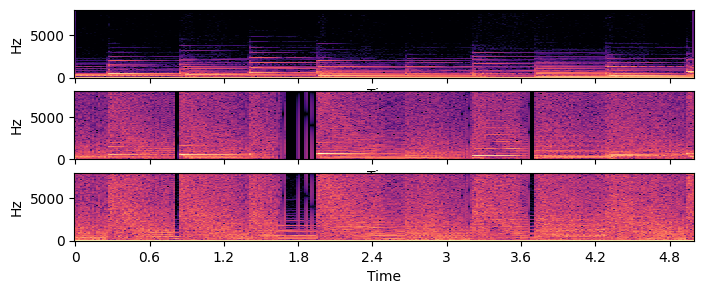

In [57]:
# Plot a short segment of the low-amplitude waveform, quantized waveform, quantization error, and their spectrograms
plot_figure(y, yq, sr=sr)

In [59]:
# Perform dithering by adding Gaussian noise
noise_var = np.max(np.abs(y))/noise_var_ratio         # Variance of Gaussian noise for dithering
z = y + np.random.normal(0, noise_var, yq.shape[0])
zq = quantize(z, n_bits=n_bits, xmax=1)

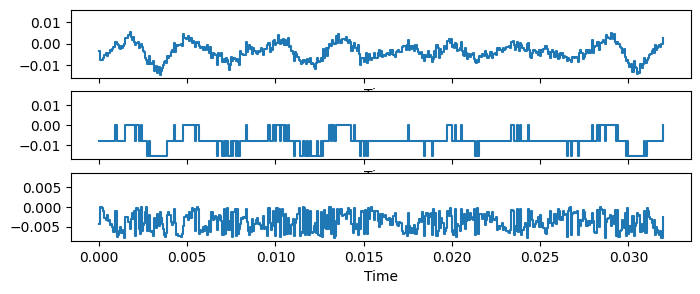

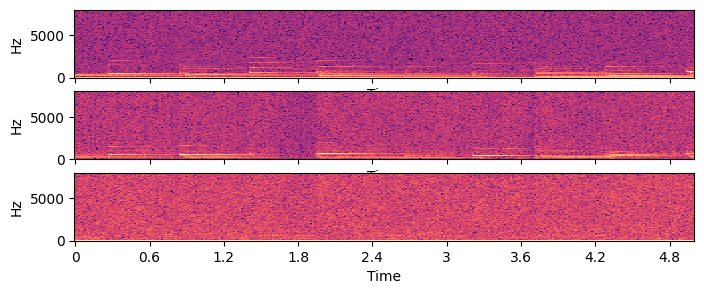

In [60]:
# Plot a frame of dithered signal, the quantization error, and their spectrograms
plot_figure(z, zq, sr=sr)

In [61]:
# Listen to the original waveform
Audio(data=x, rate=sr)

In [62]:
# Listen to the quantized waveform
Audio(data=yq, rate=sr)

In [63]:
# Listen to the dithered waveform
Audio(data=zq, rate=sr)